In [12]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys
from copy import deepcopy
from datetime import datetime
import json

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import dataset
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/var/data/opto-coproc/"
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = Path("data")  # Local data cache; i.e. not reading from the opto-coproc folder.
OUT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = OUT_DIR / "tta_sweep"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

# Initialize Hydra with the configuration directory
with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    # Compose the configuration
    cfg = compose(config_name="config")   # i.e. conf/config.yaml

DEVICE = "cuda"  # cfg.device
WINDOW_SIZE = cfg.data.trial_len

# Model directories we want to evaluate
MODEL_PATHS = {
    # "50_5_coadapt": Path("test/50_5_coadapt").resolve(),
    # "50_5_inner": Path("test/50_5_inner").resolve(),
    # "50_25_coadapt": Path("test/50_25_coadapt").resolve(),
    # "50_25_inner": Path("test/50_25_inner").resolve(),
    "100_25_rr32_coadapt": Path("test/100_25_rr32_coadapt").resolve(),
    "100_25_rr32_inner": Path("test/100_25_rr32_inner").resolve(),
}
PRIMARY_MODEL_KEY = "100_25_rr32_coadapt"

all_session_ids = [m.session_id for m in meta]
held_in_sessions_map = {}
held_out_sessions_map = {}

for model_name, model_path in MODEL_PATHS.items():
    #TODO: consistent naming
    if (model_path / "hisi_nf_1.torch").exists():
        hisi_path = model_path / "hisi_nf_1.torch"
    elif (model_path / "hisi.torch").exists():
        hisi_path = model_path / "hisi.torch"
    if not hisi_path.exists():
        raise FileNotFoundError(f"Missing held-in sessions file for {model_name}: {hisi_path}")

    held_in_sessions = torch.load(hisi_path)
    held_in_sessions_map[model_name] = held_in_sessions

    held_out_sessions = sorted(set(all_session_ids) - set(held_in_sessions))
    held_out_sessions_map[model_name] = held_out_sessions

    print(
        f"{model_name}: {len(held_in_sessions)} held-in / {len(held_out_sessions)} held-out sessions"
    )

shared_held_out_session_ids = set(all_session_ids)
for sessions in held_out_sessions_map.values():
    shared_held_out_session_ids &= set(sessions)

shared_held_out_session_ids = sorted(shared_held_out_session_ids)
if not shared_held_out_session_ids:
    raise ValueError("No shared held-out sessions found across all model directories")

print(
    f"Shared held-out sessions ({len(shared_held_out_session_ids)} candidates): "
    f"{shared_held_out_session_ids[:5]}{'...' if len(shared_held_out_session_ids) > 5 else ''}"
)

held_in_session_ids = held_in_sessions_map[PRIMARY_MODEL_KEY]
held_out_session_ids = held_out_sessions_map[PRIMARY_MODEL_KEY]
BASE_MODEL_PATH = str(MODEL_PATHS[PRIMARY_MODEL_KEY])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
100_25_rr32_coadapt: 25 held-in / 28 held-out sessions
100_25_rr32_inner: 25 held-in / 28 held-out sessions
Shared held-out sessions (28 candidates): ['MonkeyG_20150908_Session2_M1', 'MonkeyG_20150908_Session3_M1', 'MonkeyG_20150908_Session4_M1', 'MonkeyG_20150909_Session2_M1', 'MonkeyG_20150909_Session3_M1']...


In [13]:
# Okay, so the user can TTA a held in set if they want; we just provide
#  the sets above for our information. The real target here is adapt_session_ids...

# Use a held-out session that is shared across all model directories
adapt_session_ids = []
for sid in shared_held_out_session_ids:
    if len(adapt_session_ids) > 5:
        break
    path = os.path.join(DATA_DIR, sid, EMBEDDING_REST_SUBDIR, "er.torch")
    if os.path.exists(path):
        adapt_session_ids.append(sid)

if not adapt_session_ids:
    raise ValueError("No shared held-out session with cached rest embeddings found")

print(f"Using held-out session for TTA: {adapt_session_ids}")
print(f"Shared held-out session candidates available: {len(shared_held_out_session_ids)}")

# This batch size may use up all mem if we have too many sessions, but it's a useful heuristic...
batch_size = 7500 * len(adapt_session_ids)
d, held_out_session_ids = multisession.load_stim_batched(                                                             
    batch_size=batch_size,                                                               
    window_size=WINDOW_SIZE,                                                               
    session_subdir="torchraw",                                                     
    data_dir=DATA_DIR,
    held_in_session_ids=adapt_session_ids,
    num_held_out_sessions=0,                                                      
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

# Gather cached rest embeddings...
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

# Load rest embeddings for the selected held-out session
embeddings_rest_heldout = multisession.load_rest_embeddings(adapt_session_ids, device=DEVICE)
embeddings_rest.update(embeddings_rest_heldout)


Using held-out session for TTA: ['MonkeyG_20150914_Session3_S1', 'MonkeyG_20150915_Session2_S1', 'MonkeyG_20150915_Session4_S1', 'MonkeyG_20150917_Session3_M1', 'MonkeyG_20150917_Session3_S1', 'MonkeyG_20150918_Session1_M1']
Shared held-out session candidates available: 28


In [14]:
# Batch sizes will be:
print("Batch shapes:")
print("Train")
b = next(iter(data_train))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_train):
    print(batch[k0][0].shape)

print("Test")
b = next(iter(data_test))
k = list(b.keys())
k0 = k[0]

for batch in iter(data_test):
    print(batch[k0][0].shape)

Batch shapes:
Train
torch.Size([5000, 20, 93])
Test
torch.Size([2500, 20, 93])


In [16]:
# Make the model. Note that AEs will still be PCA warm-started, and normalizers too.
# Cfg needs to match the original here
# TODO: we probably want to save cfg in the future and just load it...

cfg.training.epochs = 12001
cfg.latent_dim = 85
cfg.tbfm.module.num_bases = 100
cfg.ae.training.lambda_ae_recon = 0.03
cfg.ae.use_two_stage = False
cfg.ae.two_stage.freeze_only_shared = False
cfg.ae.two_stage.lambda_mu = 0.01
cfg.ae.two_stage.lambda_cov = 0.01
cfg.tbfm.training.lambda_fro = 75.0

cfg.meta.is_basis_residual = True
cfg.meta.basis_residual_rank = 32
cfg.meta.training.lambda_l2 = 1e-2

cfg.meta.training.coadapt = True  # Enable co-adaptation of embeddings

model_path = os.path.join(BASE_MODEL_PATH, "model_nf_1.torch") if os.path.exists(os.path.join(BASE_MODEL_PATH, "model_nf_1.torch")) else os.path.join(BASE_MODEL_PATH, "model.torch")
ms = multisession.build_from_cfg(cfg, data_train, base_model_path=model_path, device=DEVICE)

# TODO: sample efficiency experiment

Building and fitting normalizers...
Building and warm starting AEs...
Loading base TBFM from file...
BOOM! Dino DNA!


In [17]:
# Let's do a silly validation: load one of the *held in* sessions and use the warm started AE and normalizers.
# This should get okay-ish performance?

# TODO: 2 versions:
#  * PCA warm start and no further AE adaptation
#  * With adaptation after warm start

# TODO: sample efficiency experiment

# Run TTA with both strategies for comparison
results_meta = {}  # coadapt_embeddings=False (meta-learning)
results_coadapt = {}  # coadapt_embeddings=True (joint optimization)


print("Running TTA with co-adaptation strategy (coadapt_embeddings=True)...")
embeddings_stim_coadapt, results_coadapt = multisession.test_time_adaptation(
    cfg,
    ms,
    embeddings_rest,
    data_train,
    epochs=12001,
    data_test=data_test,
    ae_warm_start=True,
    adapt_ae=True,
    support_size=300,
    coadapt_embeddings=True,  # Co-adaptation strategy
    quiet=False,
)

print("Running TTA with meta-learning strategy (coadapt_embeddings=False)...")
embeddings_stim_meta, results_meta = multisession.test_time_adaptation(
    cfg,
    ms,
    embeddings_rest,
    data_train,
    epochs=12001,
    data_test=data_test,
    ae_warm_start=True,
    adapt_ae=True,
    support_size=300,
    coadapt_embeddings=False,  # Meta-learning strategy
    quiet=False,
)



print(f"Co-adaptation TTA R²: {results_coadapt['final_test_r2']:.4f}")
print(f"Meta-learning TTA R²: {results_meta['final_test_r2']:.4f}")

# Determine which strategy performed better
if results_meta['final_test_r2'] > results_coadapt['final_test_r2']:
    better_strategy = "Meta-learning"
    r2_diff = results_meta['final_test_r2'] - results_coadapt['final_test_r2']
else:
    better_strategy = "Co-adaptation"  
    r2_diff = results_coadapt['final_test_r2'] - results_meta['final_test_r2']

print(f"Better strategy: {better_strategy} (R² difference: {r2_diff:.4f})")

# Store results for comparison
tta_results = {
    'meta': results_meta,
    'coadapt': results_coadapt,
    'embeddings_meta': embeddings_stim_meta,
    'embeddings_coadapt': embeddings_stim_coadapt,
}



# Warm start + adaptation, full set, 1000 epochs: 0.3702
# Warm start + adaptation, full set, 500 epochs: 0.4428
# Warm start + adaptation, full set, 300 epochs: 0.4502
# Warm start + adaptation, full set, 250 epochs: 0.4524
# Warm start + adaptation, full set, 200 epochs: 0.4487
# Warm start + adaptation, full set, 100 epochs: 0.4395
# Warm start + adaptation, full set, 20 epochs: 0.3975
# Warm start + adaptation, 300 set, 250 epochs: 0.314423
# Warm start - adaptation, full set, 250 epochs: 0.3965
# Warm start - adaptation, 300 set, 250 epochs: 0.3067
####################### Inner/outer architecture: ######################
# Warm start + adaptation, full set, 12001 epochs: 0.5486
# Warm start + adaptation, full set, 250 epochs: 0.4717
# Warm start - adaptation, 300 set, 12001 epochs: 0.3865

Running TTA with co-adaptation strategy (coadapt_embeddings=True)...
TTA: Training data filtered: 28447/30000 trials kept
TTA: Using 300 samples for adaptation (support set)
TTA: Warm starting autoencoder...
  Warm started AE for MonkeyG_20150914_Session3_S1
  Warm started AE for MonkeyG_20150915_Session2_S1
  Warm started AE for MonkeyG_20150915_Session4_S1
  Warm started AE for MonkeyG_20150917_Session3_M1
  Warm started AE for MonkeyG_20150917_Session3_S1
  Warm started AE for MonkeyG_20150918_Session1_M1
TTA: Joint optimization of AE and embeddings...
  Running 12001 joint optimization steps
  Using data_for_adaptation (300 samples)
  Joint step 0/12001, loss: 0.770922


KeyboardInterrupt: 

In [ ]:
def graph_for_sid_comparison(sid, tta_results, data_train, model, support_size=300):
    """Graph comparison between meta-learning and co-adaptation TTA results"""
    from tbfm import test
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f'TTA Comparison for Session {sid} (Held-out)', fontsize=16)
    
    strategies = ['meta', 'coadapt']
    strategy_names = ['Meta-Learning', 'Co-Adaptation']
    colors = ['blue', 'red']
    
    for idx, (strategy, name, color) in enumerate(zip(strategies, strategy_names, colors)):
        results = tta_results[strategy]
        embeddings_stim = tta_results[f'embeddings_{strategy}']
        
        y_hats = results['y_hat'][sid].detach().cpu()
        y_hats_test = results['y_hat_test'][sid].detach().cpu()
        
        if results['y'] is not None:
            y = model.norms.instances[sid](results['y'][sid]).detach().cpu()
        else:
            # For coadapt case, y might be None, use test data
            y = results['y_test'][sid][2].detach().cpu()
        
        y_test = results['y_test'][sid][2].detach().cpu()

        # Test data plot - show averages across all channels
        y_test_data = results['y_test'][sid][2].detach().cpu()
        y_hats_test_data = results['y_hat_test'][sid].detach().cpu()
        
        # Average across all channels first, then across all test trials
        _y_test_avg = torch.mean(torch.mean(y_test_data, dim=2), dim=0).detach().cpu()
        _yhat_test_avg = torch.mean(torch.mean(y_hats_test_data, dim=2), dim=0).detach().cpu()
        
        axes[0, idx].plot(_y_test_avg, label="True (Avg)", color='black', linewidth=3)
        axes[0, idx].plot(_yhat_test_avg, label="Predicted (Avg)", color=color, linewidth=3)
        axes[0, idx].set_title(f'{name} - Test Data (Avg All Channels)')
        axes[0, idx].legend()
        axes[0, idx].grid(True, alpha=0.3)
        
        # Test data state dependency
        # Debug: Check if we have valid data
        print(f"Debug: y_test shape: {y_test.shape}, y_hats_test shape: {y_hats_test.shape}")
        print(f"Debug: Averaging all channels for state dependency")

        # Average across channels first, then use bin_state_percentiles
        y_test_avg_channels = torch.mean(y_test, dim=2)
        y_hats_test_avg_channels = torch.mean(y_hats_test, dim=2)
        
        # Implement binning logic inline for averaged channels (2D tensors)
        runway_length = 0
        bin_count = 5
        initial_states = y_test_avg_channels[:, runway_length]
        recs = [(initial_states[idx], idx) for idx in range(initial_states.shape[0])]
        recs.sort()
        rec_count = len(recs)
        bin_size = int(rec_count / bin_count)

        idxs = []
        for ii in range(bin_count):
            rstart = ii * bin_size
            rend = rstart + bin_size
            cidxs = [r[1] for r in recs[rstart:rend]]
            idxs.append(cidxs)

        means = []
        meanshat = []
        minval = 1e99
        maxval = -1e99
        for cidxs in idxs:
            m = torch.mean(y_test_avg_channels[cidxs, :], axis=0).detach().cpu().numpy()
            means.append(m)
            minval = min(minval, min(m))
            maxval = max(maxval, max(m))

            if y_hats_test_avg_channels is not None:
                mhat = torch.mean(y_hats_test_avg_channels[cidxs, :], axis=0).detach().cpu().numpy()
                meanshat.append(mhat)
                minval = min(minval, min(m))
                maxval = max(maxval, max(m))

        print(f"Debug: len(means): {len(means)}, means[0] shape: {means[0].shape if means else 'None'}")

        colors = plt.cm.Paired(np.linspace(0, 1, 6))  # 5 bins + 1
        linewidth = 3.0

        for bidx in range(len(means)):
            m = means[bidx]
            color = colors[bidx]
            axes[1, idx].plot(m, color=color, linewidth=linewidth, label="y" if bidx == 0 else None)

            if meanshat is not None:
                mhat = meanshat[bidx]
                axes[1, idx].plot(
                    range(0, mhat.shape[0] + 0),
                    mhat,
                    "--",
                    color=color,
                    linewidth=linewidth,
                    label="yhat" if bidx == 0 else None,
                )

        axes[1, idx].plot([0, 0], [1.1 * minval, 1.1 * maxval], "k--", linewidth=linewidth)
        axes[1, idx].set_title(f'{name} - Test State Dependency (Avg All Channels)')
        axes[1, idx].legend()
        axes[1, idx].grid(True, alpha=0.3)
    
    # R² comparison bar chart
    r2_meta = tta_results['meta']['final_test_r2']
    r2_coadapt = tta_results['coadapt']['final_test_r2']
    
    axes[0, 2].bar(['Meta-Learning', 'Co-Adaptation'], [r2_meta, r2_coadapt], 
                   color=['blue', 'red'], alpha=0.7)
    axes[0, 2].set_title('Final Test R² Comparison')
    axes[0, 2].set_ylabel('R²')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim(0, 1)
    
    # Add R² values on bars
    for i, v in enumerate([r2_meta, r2_coadapt]):
        axes[0, 2].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    # R² difference
    r2_diff = r2_coadapt - r2_meta
    axes[1, 2].text(0.5, 0.5, f'R² Difference:\nCo-adapt - Meta = {r2_diff:+.4f}', 
                    ha='center', va='center', fontsize=14, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].axis('off')

# Compare both strategies
for sid in adapt_session_ids:
    graph_for_sid_comparison(sid, tta_results, data_train, ms)


NameError: name 'tta_results' is not defined

In [ ]:
# Then: let's try on a held-out session, but full training set.

In [ ]:
# Cleared for takeoff...
# embeddings_stim, results = multisession.train_from_cfg(
#     cfg,
#     ms,
#     data_train,
#     model_optims,
#     embeddings_rest,
#     data_test=data_test,
#     test_interval=1000,
#     epochs=20001)

# 15k batch size 3000 0.6836317658424378 0.24544973075389862
# 10k batch size 3000 0.6723785549402237 0.24294960126280785
# 7.5k batch size 3000 0.6306539237499237 0.34320169389247895
# 5k batch size 

# 7.5k no ae coadapt: 

NameError: name 'model_optims' is not defined

In [1]:
# Comprehensive TTA sweep across both model directories and multiple support sizes
print("\n" + "=" * 80)
print("Evaluating TTA performance for both model directories across support sizes")
print("=" * 80)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_path = RESULTS_DIR / f"tta_sweep_{timestamp}.log"
plot_path = RESULTS_DIR / f"tta_support_{timestamp}.png"
json_path = RESULTS_DIR / f"tta_support_{timestamp}.json"

SUPPORT_SIZES = [50, 100, 250, 500, 1000, 2500, 5000]
TTA_STRATEGIES = {
    "coadapt": {"label": "Co-Adaptation", "coadapt_embeddings": True},
    # "maml": {"label": "MAML (Meta-Learning)", "coadapt_embeddings": False},
}
MODEL_NAMES = list(MODEL_PATHS.keys())


def clone_cfg_for_eval(base_cfg):
    """Deep copy Hydra config so per-run mutations do not leak."""
    return OmegaConf.create(deepcopy(OmegaConf.to_container(base_cfg, resolve=True)))


def prepare_embeddings_for_model(model_key):
    """Load rest embeddings for a model's held-in sessions plus the shared held-out session."""
    session_ids = held_in_sessions_map[model_key]
    embeds = multisession.load_rest_embeddings(session_ids, device=DEVICE)
    embeds.update(multisession.load_rest_embeddings(adapt_session_ids, device=DEVICE))
    return embeds


# Cache embeddings per model to avoid repeated disk reads
embeddings_cache = {name: prepare_embeddings_for_model(name) for name in MODEL_NAMES}

# Storage for results
tta_comparison = {
    model_key: {strategy_key: [] for strategy_key in TTA_STRATEGIES}
    for model_key in MODEL_NAMES
}
tta_runs = []

jobs = [
    (model_key, support_size, strategy_key)
    for model_key in MODEL_NAMES
    for support_size in SUPPORT_SIZES
    for strategy_key in TTA_STRATEGIES.keys()
]

with open(log_path, "w", buffering=1, encoding="utf-8") as log_stream:
    def log_line(message=""):
        print(message, flush=True)
        log_stream.write(message + "\n")
        log_stream.flush()

    log_line(f"TTA sweep started at {timestamp}")
    log_line(f"Adapt session(s): {adapt_session_ids}")
    log_line(f"Support sizes: {SUPPORT_SIZES}")

    progress = tqdm.tqdm(jobs, desc="TTA grid", leave=False)
    for model_key, support_size, strategy_key in progress:
        strategy_cfg = TTA_STRATEGIES[strategy_key]
        status_msg = (
            f"Running | Strategy={strategy_cfg['label']:<24} | "
            f"Support={support_size:>5} | Model={model_key:<15}"
        )
        log_line(status_msg)
        progress.set_postfix({
            "model": model_key,
            "support": support_size,
            "strategy": strategy_key,
        })

        cfg_eval = clone_cfg_for_eval(cfg)
        model_file = MODEL_PATHS[model_key] / "model_nf_1.torch" if (MODEL_PATHS[model_key] / "model_nf_1.torch").exists() else MODEL_PATHS[model_key] / "model.torch"

        ms_eval = multisession.build_from_cfg(
            cfg_eval,
            data_train,
            base_model_path=str(model_file),
            device=DEVICE,
        )

        _, strategy_results = multisession.test_time_adaptation(
            cfg_eval,
            ms_eval,
            embeddings_cache[model_key],
            data_train,
            epochs=7001,
            data_test=data_test,
            ae_warm_start=True,
            adapt_ae=True,
            support_size=support_size,
            coadapt_embeddings=strategy_cfg["coadapt_embeddings"],
            quiet=True,
        )

        final_r2 = strategy_results["final_test_r2"]
        tta_comparison[model_key][strategy_key].append((support_size, final_r2))
        tta_runs.append(
            {
                "model": model_key,
                "support_size": support_size,
                "strategy": strategy_key,
                "r2": final_r2,
            }
        )

        log_line(
            f"Run complete | TTA Strategy={strategy_cfg['label']:<24} | "
            f"Support={support_size:>5} | Model={model_key:<15} | R²={final_r2:.4f}"
        )

        # Explicitly release GPU memory tied to this model before the next run
        del ms_eval
        torch.cuda.empty_cache()

    log_line("\nCompleted TTA sweep. Summary of results:")
    for entry in sorted(tta_runs, key=lambda x: (x["strategy"], x["support_size"], x["model"])):
        strategy_label = TTA_STRATEGIES[entry["strategy"]]["label"]
        log_line(
            f"  Strategy={strategy_label:<24} | Support={entry['support_size']:>5} | "
            f"Model={entry['model']:<15} | R²={entry['r2']:.4f}"
        )



Evaluating TTA performance for both model directories across support sizes


NameError: name 'datetime' is not defined

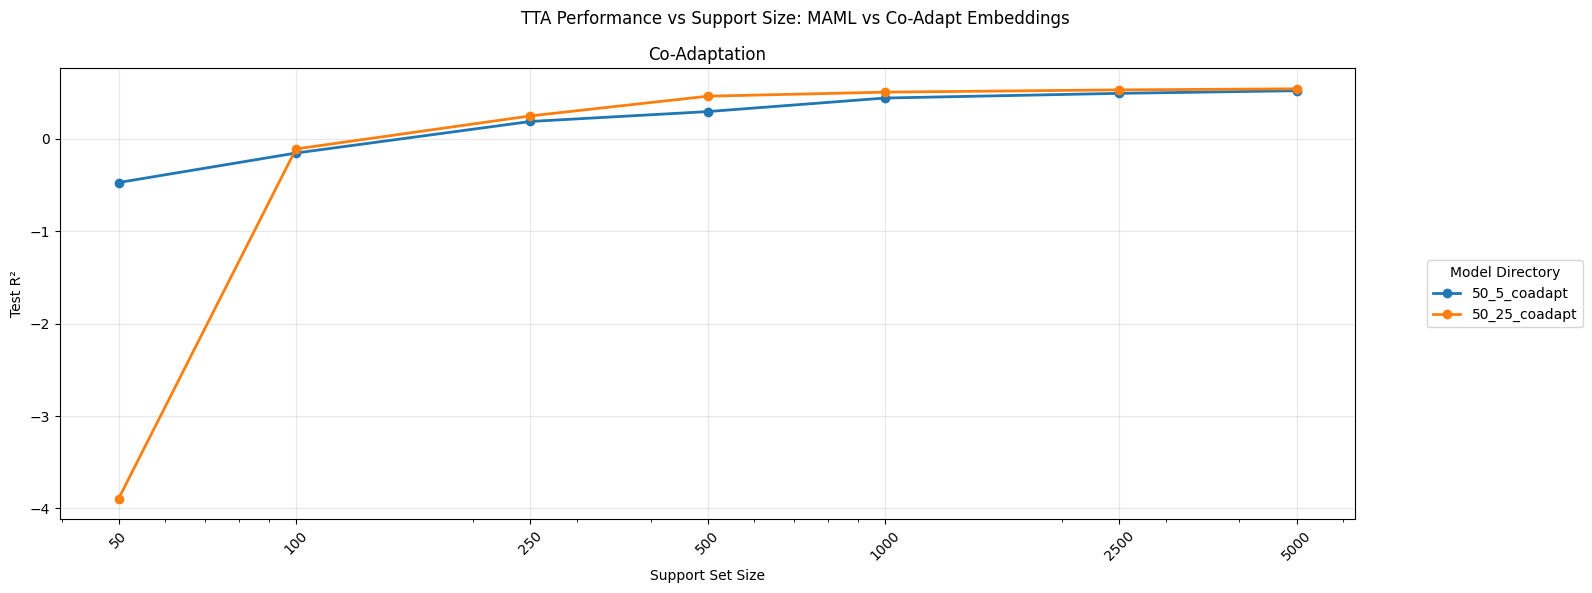

Saved plot to data/tta_sweep/tta_support_20251114_150520.png
Saved JSON summary to data/tta_sweep/tta_support_20251114_150520.json
Streaming log captured at data/tta_sweep/tta_sweep_20251114_150520.log


In [ ]:
# Persist structured results for downstream analysis
tta_support_results = {
    "metadata": {
        "timestamp": timestamp,
        "adapt_session_ids": adapt_session_ids,
        "support_sizes": SUPPORT_SIZES,
        "models": MODEL_NAMES,
    },
    "strategies": TTA_STRATEGIES,
    "grid": tta_comparison,
    "runs": tta_runs,
}

with open(json_path, "w", encoding="utf-8") as f_json:
    json.dump(tta_support_results, f_json, indent=2)

# Plot comparison: subplot per strategy showcasing both model directories
fig, axes = plt.subplots(1, len(TTA_STRATEGIES), figsize=(16, 6), sharey=True)
if len(TTA_STRATEGIES) == 1:
    axes = [axes]

for ax, (strategy_key, strategy_cfg) in zip(axes, TTA_STRATEGIES.items()):
    for model_key in MODEL_NAMES:
        data_points = sorted(tta_comparison[model_key][strategy_key], key=lambda x: x[0])
        support_vals = [dp[0] for dp in data_points]
        r2_vals = [dp[1] for dp in data_points]
        ax.plot(
            support_vals,
            r2_vals,
            marker="o",
            linewidth=2,
            label=model_key,
        )

    ax.set_title(strategy_cfg["label"])
    ax.set_xlabel("Support Set Size")
    ax.set_xscale("log")
    ax.set_xticks(SUPPORT_SIZES)
    ax.set_xticklabels([str(s) for s in SUPPORT_SIZES], rotation=45)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Test R²")
axes[-1].legend(title="Model Directory", bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.suptitle("TTA Performance vs Support Size: MAML vs Co-Adapt Embeddings")
plt.tight_layout()
fig.savefig(plot_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Saved plot to {plot_path}")
print(f"Saved JSON summary to {json_path}")
print(f"Streaming log captured at {log_path}")